# Cue Reward Association 

In this simple meta-learning task, one of four input cues is arbitrarily chosen as a *target cue*. The agent is repeatedly shown two random cues in succession, and then a *response cue* during which the agent must respond with a 1 if the target was part of the pair, or 0 otherwise. 


**Google Drive Set-up:**


In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# project folder, e.g. 'project submissions/A09_A10_A54'
# $$ for us - 'DSc Term Project/'
FOLDERNAME = 'DSc Term Project/Task 1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# test - this notebooks name should show up:
# is oserror - restart runtime
%cd /content/drive/My\ Drive/$FOLDERNAME
%ls 

KeyboardInterrupt: ignored

**Import Statements:**


In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torch.optim import lr_scheduler

import numpy as np
import time
import pickle
import random
from tqdm.autonotebook import tqdm
from graphics import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots



np.set_printoptions(precision=4)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

**GPU Set-up:**

You have an option to use GPU by setting the flag to `True` below.

The global variables `dtype` and `device` will control the data types throughout this notebook. 

You need to manually switch to a GPU device. You can do this by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`. Note that you have to rerun the cells from the top since the kernel gets restarted upon switching runtimes.

In [0]:
# flag
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.float32
else:
    device = torch.device('cpu')
    dtype = torch.float32

print('Using Device:', device)

Using Device: cuda


### Training

The cells in this section define utility functions required by the `train()` function, which is given in the last cell.

**Creating Networks:**

We will use 4 different types of recurrent neural networks (RNNs) to show the effect of modulation and plasticity on the accumulated reward in this task. These are defined in `utils/networks.py`. In our experiments we will analyse the following RNNs:
1. Non-Plastic, Non-Modulated  `NP`
2. Plastic, Non-Modulated `NM`
3. Plastic, Simple Modulation `SM`
4. Plastic, Retro Modulation `RM`

We define a function `get_network()` that takes a dictionary `params` (defined later) holding the parameters required for the networks as well as a variable `type` dictating which of the RNNs is to be returned. It also migrates the model to the GPU, if available.


In [0]:
from utils.networks import *


def get_network():
    # determine which RNN to return
    net_type = params['net_type']
    if net_type == 'NP':
        RNN = NonPlastic_NonModulated_RNN(params)
    elif net_type == 'NM':
        RNN = Plastic_NonModulated_RNN(params)
    elif net_type == 'SM':
        RNN = Plastic_SimpleModulated_RNN(params)
    else:
        RNN = Plastic_RetroactiveModulated_RNN(params)

    # move to GPU and return, if possible
    RNN.to(device=device, dtype=dtype)
    return RNN
  

**Visualizations:**

We define a function `start_graphics()` to add visualizations so the activities performed in this task are better understood. We have used `utils/graphics.py`, a Python library developed by *Zelle*.


In [0]:
#from utils.graphics import *

def start_graphics():
    if params['visualise']:
        # set title and background
        win = GraphWin("Cue Visualization", 750, 700)
        win.setBackground('light blue')

        # lists to hold the cues
        GraphicsCues=[]
        MainCues=[]

        # create the cues and store in GraphicsCues[]
        for j in range(NUM_CUE_BITS +1):
            aRectangle = Rectangle(Point(50+j*25,50), Point(75+j*25,75))
            aRectangle.setFill('black')
            aRectangle.setOutline('yellow')
            aRectangle.draw(win)
            GraphicsCues.append(aRectangle)

        # text set up
        message=Text(Point(300,15),'Present Cue')
        message.setTextColor('red')
        message.setStyle('bold')
        message.setSize(15)
        message.draw(win)
        m=Text(Point(650,250),'Network Response')
        m.draw(win)

        # 
        Cir = Circle(Point(650,350),50)
        Cir.setFill('yellow')
        Cir.draw(win)
        for j in range(5):
            Arr=[]
            for k in range(NUM_CUE_BITS+1):
                aRectangle = Rectangle(Point(100+j*100,100+k*25), Point(100+j*100+25,100+k*25+25))
                aRectangle.setFill('black')
                aRectangle.setOutline('yellow')
                aRectangle.draw(win)
                Arr.append(aRectangle)
            MainCues.append(Arr)
            if(j!=4):
                msg=Text(Point(100-5+j*100,650),'  Cue no '+str(j+1))
            else:
                msg=Text(Point(100-5+j*100,650),'Target Cue')
            msg.setStyle('bold')
            msg.setTextColor('green')
            msg.draw(win)

        # return
        return GraphicsCues, MainCues, win , Cir
    else:
        return None, None, None, None

#start_graphics()

**Generating Cues:**

We define a function `generate_cues()` that generates the `NUM_CUE_BITS`-bit cues required for the experiments. Of the cues generated randomly, one particular cue in each episode is chosen as the target cue. These cues, along with some additional inputs, will be fed into the RNN at each time step.

This function returns `Cues`, a list of all the random cues generated and `TargetCue`, a list which gives the target cue, for each batch.

In [0]:
## $$ VECTORISE
def generate_cues():
    Cues=[]
    TargetCue=[]
    for nb in range(params['batch_size']):

      Prescue=[]
      Prescue.append([0]*(NUM_CUE_BITS+1))   #The first cue or ( BLANK CUE ) 

      RndNumGen = random.sample(range(1,2**NUM_CUE_BITS ),NUM_CUES)  # Generating a rndom binary number from [1,2^NO_BITS_IN_CUE]
      for j in range(NUM_CUES):
          Presnum=RndNumGen[j]
          
          temp=([int(i) for i in bin(Presnum)[2:]]) 
          # Converting the number to binary 
          while(len(temp) != NUM_CUE_BITS):
              temp.insert(0,0)  # Adding leading zeros to make it equal to 20 bits
              
          temp.append(0)    # Final bit to determine go cue
          
          # GRAPHICS
          if params['visualise']:
              for bit in range(len(temp)):
                 if(temp[bit]==0 and nb==0):
                     MainCues[j][bit].setFill('white')
                 elif(temp[bit]==1 and nb==0):
                     MainCues[j][bit].setFill('black')

          Prescue.append(temp)


      # Generating the GOCUE
      GoCue=[0]*NUM_CUE_BITS   
      GoCue.append(1)
      Prescue.append(GoCue)
      Cues.append(Prescue)

      # Visualizing Target Cue
      tgtcue=random.sample(range(1,NUM_CUES+1),1)[0]
      TargetCue.append(tgtcue)


      # GRAPHICS
      if params['visualise']:
          for bit in range(NUM_CUE_BITS+1):
             if(Cues[0][tgtcue][bit]==0 and nb==0):
                 MainCues[4][bit].setFill('white')
             elif(Cues[0][tgtcue][bit]==1 and nb==0):
                 MainCues[4][bit].setFill('black')

      
    return np.asarray(Cues), np.asarray(TargetCue)

In [0]:
## $$ VECTORISE
def f(x):
    t=list(np.binary_repr(x).zfill(NUM_CUE_BITS))
    t=np.array(t).astype('int')
    t[t==0] = -1
    t=np.append(t,0)
    return np.array(t).astype('int')

# Add main cues for graphics
def vectorized_generate_cues(MainCues):
    Cues=np.zeros((params['batch_size'],NUM_CUES+2,NUM_CUE_BITS+1),dtype='int')
    TargetCue=np.zeros(params['batch_size'],dtype='int')

    Cues[:,0,:] = np.zeros(NUM_CUE_BITS+1,dtype='int')

    RndNumGen = np.random.choice( range(1,2**NUM_CUE_BITS),size=(params['batch_size'],NUM_CUES), replace=False)  # Generating a rndom binary number from [1,2^NO_BITS_IN_CUE]

    for i in range(params['batch_size']):  
        for j in range(NUM_CUES):
            Cues[i,j+1,0:NUM_CUE_BITS+1]=f(RndNumGen[i,j])
              

          
          # GRAPHICS
    if params['visualise']:
        for i in range(NUM_CUES):
            for bit in range(NUM_CUE_BITS+1):
                if(Cues[0][i+1][bit]== -1 or Cues[0][i+1][bit] == 0):
                    MainCues[i][bit].setFill('white')
                else:
                    MainCues[i][bit].setFill('black')



      # Generating the GOCUE
    GoCue=[0]*NUM_CUE_BITS   
    GoCue.append(1)
    GoCue=np.array(GoCue,dtype='int')
    Cues[:,NUM_CUES+1,0:NUM_CUE_BITS+1]=GoCue

    # Visualizing Target Cue
    TargetCue=np.random.choice(range(1,NUM_CUES+1),size=params['batch_size'],replace=True)
    # GRAPHICS
    if params['visualise']:
        for bit in range(NUM_CUE_BITS+1):
            if(Cues[0][TargetCue[0]][bit]==0 or Cues[0][TargetCue[0]][bit] ==-1 ):
                MainCues[4][bit].setFill('white')
            elif(Cues[0][TargetCue[0]][bit]==1 ):
                MainCues[4][bit].setFill('black')

    if (params['verbose']):  
        print('Cue')
        print(list(Cues))
        print('Target')
        print(list(TargetCue))
    return Cues, TargetCue
# MC=[]
# params['batch_size']=2;
# NUM_CUE_BITS=5
# C,T=vectorized_generate_cues(params,MC)
# print(C)

**Calculating Rewards:**

Here we define a function `calculate_rewards()` that takes in the following parameters and updates the `rewards` list accordingly.

1.    The list `reward` stores the reward for each batch.
2.    The array `numactionschosen` is a list which has the network's response for each batch. (Either 0 or 1).
3.  `CurrentTrialStep` holds the step number of a batch in the trial being executed. Ex : If it is 2 for a specific batch that means presently the 2nd step of the trial is being run.
4. `PresentTrailHasTarget` is a list which stores '0' if the target is present in a particular trial or '1' if the target isn't present.
5. `Cir` is a Python Graphics Object used to visualize network response.



In [0]:
## $$ VECTORISE
# note: if batch size is 16, a batch contains 16 'agents'
def calculate_rewards(numactionschosen , reward ,CurrentTrialStep , PresentTrialHasTarget, NoStepsInTrial,Cir):

    '''
    # initialise rewards as 0 and subtract penalty from agents where choice 1 was made
    rewards = np.zeros((params['batch_size'],))
    chosen_ind = np.where(numactionschosen == 1)
    rewards[chosen_ind] -= params['penalty']

    # get indices of the trials where we reached the last step
    '''


    # Calculate Reward for each batch 
    for nb in range(params['batch_size']):
        numactionchosen = numactionschosen[nb]       #Gives action chosen
        reward[nb] = 0.0

        # Here I calculate rewards based on output
        if numactionchosen == 1:
            reward[nb]-=params['penalty']

        # 
        
        # Rewarding when I get to the last step of the trial
        if CurrentTrialStep[nb]==NoStepsInTrial[nb]-1 :

            print(f'-----{nb+1}---------\nAction chosen: {numactionchosen}')
            ## GRAPHICS
            if PresentTrialHasTarget[nb]==1 and numactionchosen==1 :
                #if(nb==0):
                #    Cir.setFill('green')
                    # time.sleep(1)
                reward[nb]+=params['reward']
                print("CORRECT")
            elif PresentTrialHasTarget[nb] ==0 and numactionchosen==0:
                #if(nb==0):
                #    Cir.setFill('green')
                    #time.sleep(1)
                reward[nb]+=params['reward']
                print("CORRECT")
            else:
                #if(nb==0):
                #    Cir.setFill('red')
                    #time.sleep(1)
                reward[nb]-=params['reward']
                print("wrong!")

            if random.random() < params ['inversion_factor']:  #I've replicated this step as in the code IDK what
                reward=-reward[nb] 
            CurrentTrialStep[nb]=0
            #time.sleep(5)
        else:
            CurrentTrialStep[nb]+=1
        

    return reward

In [0]:
### This is the vectorized calculate rewards function

## $$ VECTORISE
# note: if batch size is 16, a batch contains 16 'agents'
# Add 'Cir' to list of params
def vectorised_calculate_rewards(numactionschosen , reward ,CurrentTrialStep , PresentTrialHasTarget, NoStepsInTrial,Cir):

    '''
    # initialise rewards as 0 and subtract penalty from agents where choice 1 was made
    rewards = np.zeros((params['batch_size'],))
    chosen_ind = np.where(numactionschosen == 1)
    rewards[chosen_ind] -= params['penalty']

    # get indices of the trials where we reached the last step
    '''
    # Converting arrays into np arrays for vectorization

    # Calculate Reward for each batch 

    chosen_ind = np.where(numactionschosen == 1)
    reward[chosen_ind] -= params['penalty']
    

    Batches_In_Last_Step=np.where(CurrentTrialStep == NoStepsInTrial -1)
    Batches_Not_In_Last_Step=np.where(CurrentTrialStep != NoStepsInTrial -1)

    Batches_Which_Predicted_Correct_Response=np.where(np.bitwise_xor(PresentTrialHasTarget,numactionschosen) ==0 )
    Batches_Which_Predicted_Wrong_Response=np.where(np.bitwise_xor(PresentTrialHasTarget,numactionschosen) ==1 )
    Batches_Which_Predicted_Correct_Response = np.intersect1d(Batches_Which_Predicted_Correct_Response,Batches_In_Last_Step)

    Batches_Which_Predicted_Wrong_Response = np.intersect1d(Batches_Which_Predicted_Wrong_Response,Batches_In_Last_Step)

    reward[Batches_Which_Predicted_Correct_Response]+=params['reward']
    reward[Batches_Which_Predicted_Wrong_Response]-=params['reward']

    some_random_indices=np.random.rand(params['batch_size'])
    some_random_indices=np.where(some_random_indices<params['inversion_factor'])
    reward[some_random_indices]*=-1

    CurrentTrialStep[Batches_In_Last_Step]=0
    CurrentTrialStep[Batches_Not_In_Last_Step]+=1

    if params['verbose']:
        print('Num actions chosen are : ', numactionschosen)
        print('Batches in last step: ', Batches_In_Last_Step)
        print('Right:', Batches_Which_Predicted_Correct_Response)
        print('Wrong: ', Batches_Which_Predicted_Wrong_Response)

    
    # Running Graphics Part
    if params['visualise']:
        if CurrentTrialStep[0]==NoStepsInTrial[0]-1 :

            ## GRAPHICS
            if PresentTrialHasTarget[0]==1 and numactionschosen[0]==1 :
                Cir.setFill('green')
    #         time.sleep(1)
            elif PresentTrialHasTarget[0]==0 and numactionschosen[0]==0 :
                Cir.setFill('green')
    #         time.sleep(1)
            else:
                Cir.setFill('red')
    #          time.sleep(1)

    return reward
    

**Other Utility Functions:**

Here we define some additional helper functions that help us keep our code oragnised in this notebook, and reduce the LOC in the `train()` function


In [0]:
# returns a dictionary of blank lists corresponding to the statistics
# over all episodes we wish to track in our experiments
def get_blank_statistics_dict():
    all_stats = {
        'losses' : [],
        'grad_norms' : [],
        'losses_objective' : [],
        'total_rewards' : [],
        'losses_v' : [],
        'mean_reward' : [],
        'total_rewards_batchwise' : []

    }
    return all_stats


# called at the start of each episode to individually reset the values of 
# hebb, prev, E, and plastic_weights (check architechture for more details)
# note: none of these require grads since we manually update them
def initial_zero_BH(): # used to reset prev hidden state (BxH)
    return Variable(torch.zeros(params['batch_size'], params['hidden_size']), 
                    requires_grad=False).to(device, dtype)

def initial_zero_BHH(): # used to reset E (eligibility trace), plastic_weights, and hebb
    return Variable(torch.zeros(params['batch_size'], params['hidden_size'], params['hidden_size']), 
                    requires_grad=False).to(device, dtype) # (BxHxH)



**Training Function:**

This is the main function we've used to train the network and analyze it's response over all episodes and for all batches. 


### Normal train

### vectorised train

In [0]:
def vectorized_train():
    # print current parameters as a check - global variables
    print(params)

    # set random seeds for training, so that results are comparable
    np.random.seed(params['rng_seed'])
    random.seed(params['rng_seed'])
    torch.manual_seed(params['rng_seed'])

    # create the network required determined by params['net_type']
    net = get_network()

    # initialise optimiser - we use Adam with L2 reg
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=params['learning_rate'], 
                                 weight_decay=params['lambd'])
    
    # create dictionary to keep track of stats over all episodes
    all_stats = get_blank_statistics_dict() 
    lossbetweensaves = 0
    nowtime = time.time()


    # GRAPHICS
    GraphicsCues, MainCues, win, Cir = start_graphics()
    
    
    nbtrials = [0]*params['batch_size']
    totalnbtrials = 0
    nbtrialswithcc = 0

    # loop over every episode:
    for numiter in tqdm(range(params['num_episodes'])): 
        # $$ 
        # An episode consists of several trials. In each trial, half of the total no of cues are input to the network.
        # The network , at the last step of each trial outputs 0 or 1.

        # We generate 4 random unique Cues with 20 bits and choose one to be TargetCue
        #Cues, TargetCue = vectorized_generate_cues(MainCues)
        #CurrentTrialStep = np.zeros(params['batch_size'], dtype='int')      # used to keep track of which step each trial is in
        #NoStepsInTrial = np.zeros(params['batch_size'], dtype='int')        # length of each trial
        #TrialMoves = [None]*params['batch_size']                            # The various moves to be performed in a trial 
        #PresentTrialHasTarget = np.zeros(params['batch_size'], dtype='int') # 0 if no target , 1 if target present in a trial
        #numactionschosen = np.zeros(params['batch_size'], dtype='int')      # used to keep track of the choice in each trial

        # Generate the cues. Make sure they're all different (important when using very small cues for debugging, e.g. cs=2, ni=2)
        cuedata=[]
        for nb in range(params['batch_size']):
            cuedata.append([])
            for ncue in range(NUM_CUES):
                assert len(cuedata[nb]) == ncue
                foundsame = 1
                cpt = 0
                while foundsame > 0 :
                    cpt += 1
                    if cpt > 10000:
                        # This should only occur with very weird parameters, e.g. cs=2, ni>4
                        raise ValueError("Could not generate a full list of different cues")
                    foundsame = 0
                    candidate = np.random.randint(2, size=NUM_CUE_BITS) * 2 - 1
                    for backtrace in range(ncue):
                        if np.array_equal(cuedata[nb][backtrace], candidate):
                            foundsame = 1

                cuedata[nb].append(candidate)

        # we zero out these values before each episode according to their lifetime
        # cache holds the extra inputs and outputs needed according to different network types 
        # initially cache is a list, then we convert it to a tuple
        prev = initial_zero_BH()
        cache = [prev]
        if params['net_type'] != 'NP':  # hebb is only for plastic
            hebb = initial_zero_BHH()
            cache.append(hebb)
        if params['net_type'] == 'RM':  # these are only for retroactive modulated
            E_t = initial_zero_BHH()              
            plastic_weights = initial_zero_BHH()
            cache.append(E_t)
            cache.append(plastic_weights)
        cache = tuple(cache)


        # zero out backprop gradients as well (since pytroch accumulates them)
        optimizer.zero_grad()
        
        
        # additional variables
        loss = 0                                    # loss is accumulated over the episode
        lossv = 0                                   # needed for A2C
        numactionchosen = 0                         # 0 -> not present, 1 -> present
        reward = np.zeros(params['batch_size'])     #
        sumreward = np.zeros(params['batch_size'])  #
        rewards = []                                #
        vs = []                                     # 
        logprobs = []                               # 
        dist = 0                                    #
        cues=[]
        for nb in range(params['batch_size']):
            cues.append([])
        numactionschosen = np.zeros(params['batch_size'], dtype='int32')
        
        nbtrials = np.zeros(params['batch_size'])
        nbrewardabletrials = np.zeros(params['batch_size'])
        thistrialhascorrectcue = np.zeros(params['batch_size'])
        triallength = np.zeros(params['batch_size'], dtype='int32')
        correctcue = np.random.randint(NUM_CUES, size=params['batch_size'])

        trialstep = np.zeros(params['batch_size'], dtype='int32')

        # loop over the trials in each episode
        for numstep in range(params['episode_length']): 

            ## $$ VECTORISE
            #ind_current_trial_step_zero = np.where(CurrentTrialStep == 0)

            #extra_blank_spaces = np.random.randint(size=(params['batch_size'],), NUM_CUES//2)

            #NoStepsInTrial[ind_current_trial_step_zero] = NUM_CUES + 1 + extra_blank_spaces[ind_current_trial_step_zero] + 1

            # (nb x num_cues // 2) - choices for cue to input for each batch in this trial
            #choices = np.random.choice(np.arange(1, (NUM_CUES//2)+1), size=(params['batch_size'],NUM_CUES//2))
            

            inputs = np.zeros((params['batch_size'], params['input_size']), dtype='float32')
            NBINPUTBITS=NUM_CUE_BITS+1
            for nb in range(params['batch_size']):

                if trialstep[nb] == 0:
                    thistrialhascorrectcue[nb] = 0
                    # Trial length is randomly modulated for each trial; first time step always -1 (i.e. no input cue), last time step always response-cue (i.e. NBINPUTBITS-1).
                    #triallength = params['ni'] // 2  + 3 + np.random.randint(1 + params['ni'])  # 3 fixed-cue time steps (1st, last and next-to-last) + some random nb of no-cue time steps
                    triallength[nb] = NUM_CUES // 2  + 3 + np.random.randint(NUM_CUES)  # 3 fixed-cue time steps (1st, last and next-to-last) + some random nb of no-cue time steps



                    # In any trial, we only show half the cues (randomly chosen), once each:
                    mycues = [x for x in range(NUM_CUES)]
                    random.shuffle(mycues); mycues = mycues[:len(mycues) // 2]
                    # The rest is filled with no-input time steps (i.e. cue = -1), but also with the 3 fixed-cue steps (1st, last, next-to-last)
                    for nc in range(triallength[nb] - 3  - len(mycues)):
                        mycues.append(-1)
                    random.shuffle(mycues)
                    mycues.insert(0, -1); mycues.append(NUM_CUES); mycues.append(-1)  # The first and last time step have no input (cue -1), the next-to-last has the response cue.
                    assert(len(mycues) == triallength[nb])
                    cues[nb] = mycues


                inputs[nb, :NBINPUTBITS] = 0
                if cues[nb][trialstep[nb]] > -1 and cues[nb][trialstep[nb]] < NUM_CUES:
                    #inputs[0, cues[trialstep]] = 1.0
                    inputs[nb, :NBINPUTBITS-1] = cuedata[nb][cues[nb][trialstep[nb]]][:]
                    if cues[nb][trialstep[nb]] == correctcue[nb]:
                        thistrialhascorrectcue[nb] = 1
                if cues[nb][trialstep[nb]] == NUM_CUES:
                    inputs[nb, NBINPUTBITS-1] = 1  # "Go" cue


                inputs[nb, NBINPUTBITS + 0] = 1.0 # Bias neuron, probably not necessary
                inputs[nb,NBINPUTBITS +  1] = numstep / params['episode_length']
                inputs[nb, NBINPUTBITS + 2] = 1.0 * reward[nb] # Reward from previous time step
                if numstep > 0:
                    inputs[nb, NBINPUTBITS + ADDITIONAL_INPUTS + numactionschosen[nb]] = 1  # Previously chosen action

            
            # create a tensor from the inputs and pass it into the network 
            inputsC = torch.from_numpy(inputs).to(device, dtype)
            inputs_tensor = Variable(inputsC, requires_grad=False)
            y, v, cache = net(inputs_tensor, cache)                        # y  should output raw scores, not probas

            # we apply softmax to get probabilities
            y = torch.softmax(y, dim=1)             

            # create distribution according to y and randomly choose an action accordingly
            distrib = torch.distributions.Categorical(y)
            actionschosen = distrib.sample()
            logprobs.append(distrib.log_prob(actionschosen))     # store log of proba

            numactionschosen = actionschosen.data.cpu().numpy()  # We want to break gradients
            reward = np.zeros(params['batch_size'], dtype='float32')

            
            '''
            # Function to calculate Rewards
            reward = vectorised_calculate_rewards(numactionschosen,reward,CurrentTrialStep,PresentTrialHasTarget,NoStepsInTrial,Cir)
            # print('Reward : ')
            # print(reward)
            all_stats['mean_reward'].append(np.median(reward))
            # print(np.median(reward))
            '''
            
            for nb in range(params['batch_size']):
                if numactionschosen[nb] == 1:
                    # Small penalty for any non-rest action taken
                    reward[nb]  -= params['penalty']


            ### DEBUGGING
            ## Easiest possible episode-dependent response (i.e. the easiest
            ## possible problem that actually require meta-learning, with ni=2)
            ## This one works pretty wel... But harder ones don't work well!
            #if numactionchosen == correctcue :
            #        reward = params['rew']
            #else:
            #        reward = -params['rew']


                trialstep[nb] += 1
                if trialstep[nb] == triallength[nb] - 1:
                    # This was the next-to-last step of the trial (and we showed the response signal, unless it was the first few steps in episode).
                    assert(cues[nb][trialstep[nb] - 1] == NUM_CUES or numstep < 2)
                    # We must deliver reward (which will be perceived by the agent at the next step), positive or negative, depending on response
                    if thistrialhascorrectcue[nb] and numactionschosen[nb] == 1:
                        reward[nb] += params['reward']
                    elif (not thistrialhascorrectcue[nb]) and numactionschosen[nb] == 0:
                        reward[nb] += params['reward']
                    else:
                        reward[nb] -= params['reward']

                    if np.random.rand() < params['inversion_factor']:
                        reward[nb] = -reward[nb]

                if trialstep[nb] == triallength[nb]:
                    # This was the last step of the trial (and we showed no input)
                    assert(cues[nb][trialstep[nb] - 1] == -1 or numstep < 2)
                    nbtrials[nb] += 1
                    totalnbtrials += 1
                    if thistrialhascorrectcue[nb]:
                        nbtrialswithcc += 1
                        #nbrewardabletrials += 1
                    # Trial is dead, long live trial
                    trialstep[nb] = 0
            
            
            rewards.append(reward)
            # time.sleep(3)
            vs.append(v) 
            sumreward += reward

            # This is an "entropy penalty", implemented by the sum-of-squares of the probabilities 
            # The result is to encourage diversity in chosen actions.
            loss += ( params['entropy_reward_coeff'] * y.pow(2).sum() / params['batch_size'] )




        # Episode is done, now we do the actual computations of rewards and losses for the A2C algorithm
        R = torch.zeros(params['batch_size']).to(device)
        gammaR = params['reward_discount_factor']    #Discounting factor for rewards
        for numstepb in reversed(range(params['episode_length'])) :         # Every step in an episode has a reward
            R = gammaR * R + Variable(torch.from_numpy(rewards[numstepb]), requires_grad=False).to(device)
            ctrR = R - vs[numstepb][0]
            lossv += ctrR.pow(2).sum() / params['batch_size']
            loss -= (logprobs[numstepb] * ctrR.detach()).sum() / params['batch_size']



        loss += params['lossv_coeff'] * lossv      #Coefficient for value prediction loss
        loss /= params['episode_length']
        

        # perform backprop and gradient clipping
        loss.backward()
        all_stats['grad_norms'].append(torch.nn.utils.clip_grad_norm_(net.parameters(), params['gradient_clip']))
        if numiter > 100:  # Burn-in period for meanrewards
            optimizer.step()

        # update stats
        lossnum = float(loss)
        lossbetweensaves += lossnum
        all_stats['losses_objective'].append(lossnum)
        all_stats['total_rewards'].append(sumreward.mean())
        all_stats['total_rewards_batchwise'].append(sumreward)


        if (numiter+1) % params['print_every'] == 0:
            print(f'\nThis is episode {numiter}:')
            print("lossv: ", float(lossv))
            print ("Total reward for this episode (all):", sumreward, "Dist:", dist)
          
            print(numiter, "====")
            print("Mean loss: ", lossbetweensaves / params['print_every'])
            lossbetweensaves = 0
            print("Mean reward (across batch and last", params['print_every'], "eps.): ", np.sum( all_stats['total_rewards'][-params['print_every']:])/ params['print_every'])
            print("Mean reward (across batch): ", sumreward.mean())
            previoustime = nowtime
            nowtime = time.time()
            print("Time spent on last", params['print_every'], "iters: ", nowtime - previoustime)



    return net, all_stats




### Experiments:

**Initialising Default Parameters:**

Here we define a global dictionary `params` containing all the parameters required during training and those required to create the recurrent neural networks. These values are changed as required before training for different experiments, by directly updating the values required. Therefore, most of the values defined in the following cell are NOT updated here itself. The exceptions to this rule are the hyperparameters: once their optimum values are determined in `experiment 2`, the default values are updated to reflect the results of this experiment.

Thus, we also keep a copy of these default parameters in `default_params`, and define a function `reset_parameters()` that will reset all parameters. This is called before the start of each experiment, and it helps us to keep our experiments controlled easily.

We also create a function `alter_params_for_save()` to remove functions from the dictionary so it can be pickled.

We also initialise some other constants, for example number of additional inputs.

In [0]:
# constants
NUM_CUE_BITS = 20
NUM_CUES = 4
ADDITIONAL_INPUTS = 4 # 1 input for the previous reward, 1 input for numstep, 1 unused,  1 "Bias" input
NUM_ACTIONS = 2   # YES OR NO
TOTAL_NUM_INPUTS =  NUM_CUE_BITS + 1 + ADDITIONAL_INPUTS + NUM_ACTIONS

# these are kept constant while experimenting!
params = {
    # hyperparameters to be found out and fixed for optimum training (experiment 2)
    'learning_rate' : 1e-4 ,
    'hidden_size' : 200 ,
    'lambd' : 0 ,      # for l2 norm reg 

    # parameters for other experiments 
    'net_type' : 'NP' ,
    'fully_modulated' : True ,
    'neuromod_neurons' : 1 ,
    
    # other parameters
    'episode_length' : 120 , 
    'num_episodes' : 60000 ,
    'batch_size' : 10 ,
    'print_every' : 10000 ,  
    'rng_seed' : 0 ,

    'penalty' :  0  , # Wall hitting penalty - not needed here
    'reward' : 1 ,
    'gradient_clip' : 2.0 ,  
    'activation' : torch.tanh ,
    'parameter_init_function' : nn.init.xavier_normal_ ,
    
    'eta_init_value' : 0.1 ,
    'neuromod_activation' : torch.tanh ,
    'inversion_factor' : 0 ,   # Probability Factor for inversion
    'entropy_reward_coeff' : 0.1 ,  
    'lossv_coeff': .1 ,        # Coefficient for value prediction loss
    'reward_discount_factor' : 0.9 ,

    'input_size' : TOTAL_NUM_INPUTS ,
    'output_size' : NUM_ACTIONS ,

    'verbose' : False ,
    'visualise': False
}


default_params = params
def reset_parameters():
    global params
    params = default_params

# make sure to call reset after this
def alter_params_for_save():
    params['activation'] = None
    params['neuromod_activation'] = None
    params['parameter_init_function'] = None

**Experiment 1: Different Types of Networks**

Here we see the effect of the type of recurrent neural network on the reward accumulated and the total loss.
We choose some reasonable values for the hyperparameters now, and then set them to the optimum values later in `experiment 3` and repeat this study to validate our results.

Only the parameter `net_type` is changed here.


In [0]:
reset_parameters()

# Plastic, Retroactive Modulation
params['net_type'] = 'RM'
RM_model, RM_stats = vectorized_train()

save = train(params)
savepath='saved/Final'+params['net_type']+'.pt'
torch.save(save,savepath)
print("Saved!")

{'learning_rate': 0.0001, 'hidden_size': 200, 'lambd': 0, 'net_type': 'RM', 'fully_modulated': True, 'neuromod_neurons': 1, 'episode_length': 120, 'num_episodes': 60000, 'batch_size': 10, 'print_every': 10000, 'rng_seed': 0, 'penalty': 0, 'reward': 1, 'gradient_clip': 2.0, 'activation': <built-in method tanh of type object at 0x7f40bb0fa300>, 'parameter_init_function': <function xavier_normal_ at 0x7f40732b7bf8>, 'eta_init_value': 0.1, 'neuromod_activation': <built-in method tanh of type object at 0x7f40bb0fa300>, 'inversion_factor': 0, 'entropy_reward_coeff': 0.1, 'lossv_coeff': 0.1, 'reward_discount_factor': 0.9, 'input_size': 27, 'output_size': 2, 'verbose': False, 'visualise': False}
Corrected !!


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



This is episode 9999:
lossv:  92.59998321533203
Total reward for this episode (all): [  5.   2.   6.   2.  -4. -10.  -3.   1.   3.   3.] Dist: 0
9999 ====
Mean loss:  0.12921971251711983
Mean reward (across batch and last 10000 eps.):  -0.00583
Mean reward (across batch):  0.5
Time spent on last 10000 iters:  3477.0410449504852

This is episode 19999:
lossv:  108.4305419921875
Total reward for this episode (all): [ 5. -1.  4.  8.  9.  2.  9. -5.  0.  2.] Dist: 0
19999 ====
Mean loss:  0.12848421171944646
Mean reward (across batch and last 10000 eps.):  0.018000000000000002
Mean reward (across batch):  3.3
Time spent on last 10000 iters:  3686.3760743141174

This is episode 29999:
lossv:  89.99372100830078
Total reward for this episode (all): [-4.  1.  6. -3.  8.  1.  3. -5.  4.  2.] Dist: 0
29999 ====
Mean loss:  0.1283360780517949
Mean reward (across batch and last 10000 eps.):  0.0628
Mean reward (across batch):  1.3
Time spent on last 10000 iters:  3695.8134684562683

This is episo

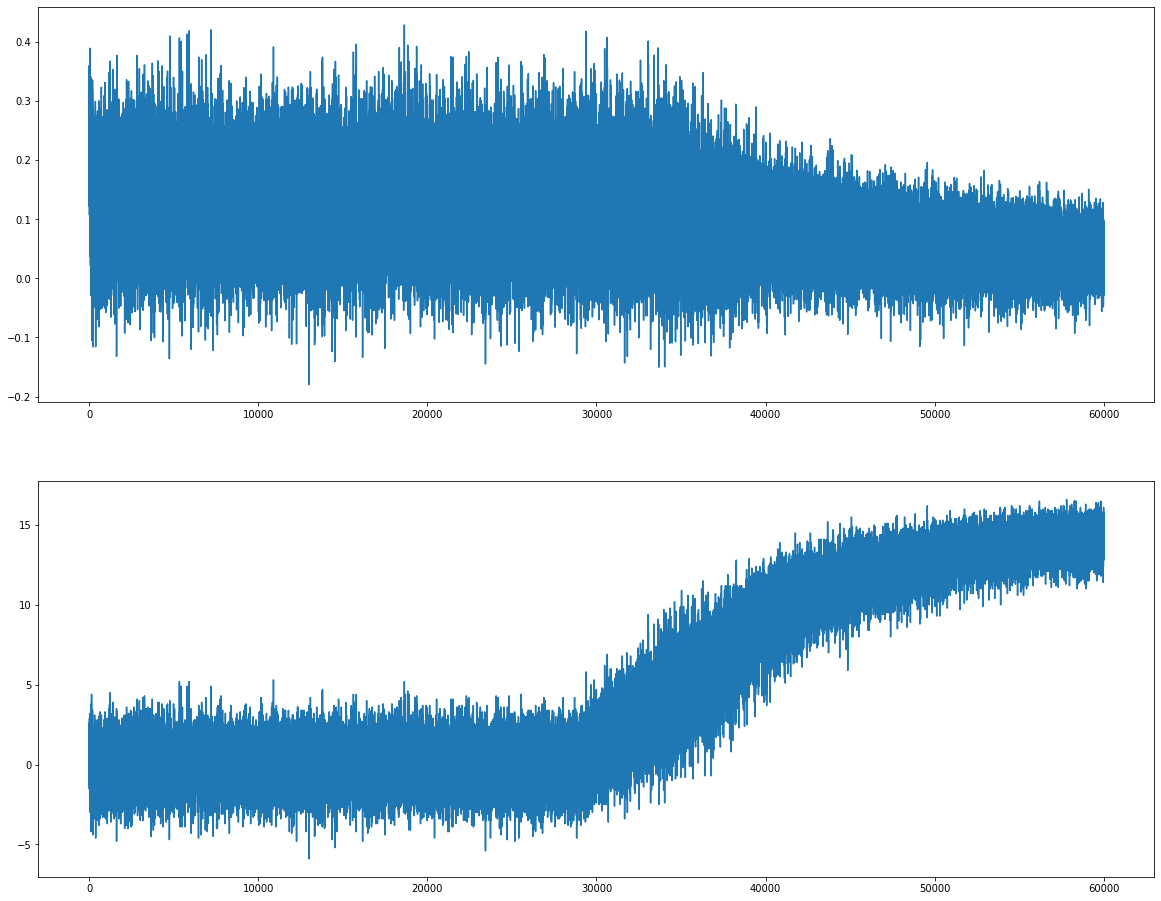

In [0]:
# plot loss over time
plt.subplot(2,1,1)
x = np.arange(params['num_episodes'])
# y_NP = NP_stats['losses_objective']
# y_NM = NM_stats['losses_objective']
#y_SM = SM_stats['losses_objective']
y_RM = RM_stats['losses_objective']
# plt.plot(x,y_NP)
# plt.plot(x,y_NM)
#plt.plot(x,y_SM)
plt.plot(x,y_RM)

# plot rewards over time
plt.subplot(2,1,2)
# y_NP = NP_stats['total_rewards']
#y_NM = NM_stats['mean_reward']
#y_SM = SM_stats['total_rewards']
y_RM = RM_stats['total_rewards']
# plt.plot(x,y_NP)
#plt.plot(x,y_NM)
#plt.plot(x,y_SM)
plt.plot(x,y_RM)
plt.show()

In [0]:
# save location
SAVE_FOLDER = "saved/experiment_1/"

# save
a_file = open(SAVE_FOLDER + params['net_type'] + "_stats.pkl", "wb")
pickle.dump(RM_stats, a_file) ## CHANGE THIS ACCORDINGLY
a_file.close()

alter_params_for_save()
a_file = open(SAVE_FOLDER + params['net_type'] + "_params.pkl", "wb")
pickle.dump(params, a_file) 
a_file.close()

torch.save(RM_model.state_dict(), SAVE_FOLDER + params['net_type'] + "_model.pt") ## THIS AS WELL

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


### Results

We can see...